## Improved Single Match xG Infographic

In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
from highlight_text import fig_text, ax_text

import utils.probability_functions as pf
from utils.cleaning import create_team_df, align_dfs, chance_quality
from utils.metadata import *

mpl.rcParams['font.family'] = 'Alegreya Sans'

#### Load data

In [2]:
#load data
comp = 'gw32'
df = pd.read_csv(f'../../data/understat/liverpool/{comp}.csv')

#### Data preperation

In [3]:
# Create a df for each team (will only work as long as both teams took a shot)
df_home, df_away = create_team_df(df)

In [4]:
home_team, away_team = df_home['team'][0], df_away['team'][0]

Align dataframes so both spans from minute 0 to minute of last shot

In [5]:
df_home_final, df_home_final1, df_away_final, df_away_final1 = align_dfs(df, df_home, df_away)

In [6]:
home_min_final = list(df_home_final['minute'].unique())
away_min_final = list(df_away_final['minute'].unique())

home_cum_xG_final = np.array(df_home_final1)
away_cum_xG_final = np.array(df_away_final1)

#home_min_final = list(home_min_final)
#away_min_final = list(away_min_final)

#home_cum_xG_final = list(home_cum_xG_final)
#away_cum_xG_final = list(away_cum_xG_final)

#### Calculate scoreline probabilities

In [7]:
#find total xG
home_total_xG = '{:.2f}'.format(round(home_cum_xG_final[-1], 2))
away_total_xG = '{:.2f}'.format(round(away_cum_xG_final[-1], 2))

# Get probability of all scorelines from 0-0 to 9-9
home_goal_probs, away_goal_probs, scoreline_probs = pf.score_probability(float(home_total_xG),
                                                                         float(away_total_xG),
                                                                         num_goals=10)

#### Prepare data for plotting

In [8]:
# Create xs and ys for bar plots 
home_xs, home_ys = zip(*home_goal_probs)
away_xs, away_ys = zip(*away_goal_probs)

# Get number of goals for each team
home_goals = len(df_home[df_home['result'] == 'Goal'])
away_goals = len(df_away[df_away['result'] == 'Goal'])

home_color = home_colors[home_team]
away_color = home_colors[away_team]

#### Scoreline probabilities

In [9]:
for i in range(3):
    print(scoreline_probs[i])

[(2, 1), 0.08071790027155822]
[(3, 1), 0.0704936329038275]
[(2, 2), 0.06457432021724659]


#### Calculate win, loss and draw probabilities

In [10]:
home_prob, away_prob, draw_prob = pf.win_loss_draw_probs(scoreline_probs)

home_prob = int(round(home_prob*100, 0))
draw_prob = int(round(draw_prob*100, 0))
away_prob = int(round(away_prob*100, 0))

#concat to list
home_away_draw_probs = pd.DataFrame({'outcomes': ['home', 'away', 'draw'], 'probs': [home_prob, away_prob, draw_prob]})

#### The improved match xG Infographic

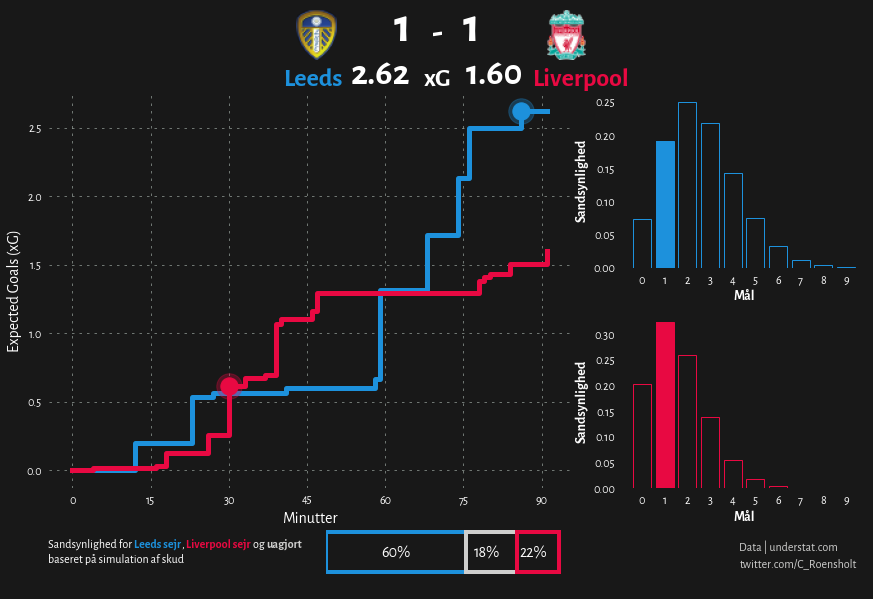

In [13]:
fig, axd = plt.subplot_mosaic(
    '''
    BBC
    BBD
    .A.
    ''',
    constrained_layout=True, figsize=(12,7),
    gridspec_kw={'height_ratios':[0.4, 0.4, 0.1]})
                 #'width_ratios':[0.15, 0.5, 0.25]})


#ax1, ax2, ax3, ax4 = axd.values()
fig.set_facecolor(facecolor)

# ------------- ax 1 -------------- #
axd['A'].set_facecolor(facecolor)
#set up our base layer
axd['A'].tick_params(axis='x', bottom=False, colors=facecolor, labelsize=12)
axd['A'].tick_params(axis='y', left=False, colors=facecolor, labelsize=12)

axd['A'].spines["top"].set_visible(False)
axd['A'].spines["right"].set_visible(False)
axd['A'].spines["bottom"].set_visible(False)
axd['A'].spines["left"].set_visible(False)

# Plot bars
home = axd['A'].barh(0.5, home_away_draw_probs['probs'][0], edgecolor=home_color, linewidth=4, fill=False, height=0.8)
draw = axd['A'].barh(0.5, home_away_draw_probs['probs'][1],
                     left=home_away_draw_probs['probs'][0], edgecolor=text_color, linewidth=4, fill=False, height=0.8)
away = axd['A'].barh(0.5, home_away_draw_probs['probs'][2],
                     left=home_away_draw_probs['probs'][0]+home_away_draw_probs['probs'][1],
                     edgecolor=away_color, linewidth=4, fill=False, height=0.8)

# Set texts
# Home
axd['A'].text(x=home_prob/2, y=0.4, s=f'{home_prob}%',
              color='w', ha='center', size=16, fontweight='regular')
#ax1.text(x=home_prob/2, y=-0.3, s=f'Sejr',
#        color='w', ha='center', size=12)
# Draw
axd['A'].text(x=home_prob+draw_prob/2, y=0.4, s=f'{draw_prob}%',
              color='w', ha='center', size=16, fontweight='regular')
#ax1.text(x=home_prob+draw_prob/2, y=-0.3, s=f'Uafgjort',
#        color='w', ha='center', size=12)
# Away
axd['A'].text(x=home_prob+draw_prob+away_prob/2, y=0.4, s=f'{away_prob}%',
              color='w', ha='center', size=16, fontweight='regular')
#ax1.text(x=home_prob+draw_prob+away_prob/2, y=-0.3, s=f'Sejr',
#        color='w', ha='center', size=12)


# ------------- ax 2 -------------- #
axd['B'].set_facecolor(facecolor)
#set up our base layer
axd['B'].tick_params(axis='x', bottom=False, labelsize=12, colors='w')
axd['B'].tick_params(axis='y', left=False, labelsize=12, colors='w')


axd['B'].set_frame_on(False)

#set grid
axd['B'].grid(ls=(0, (5, 10)), lw=.5, color='#c7d5cc', axis='both', zorder=1)
spines = ['top','bottom','left','right']
for x in spines:
    if x in spines:
        axd['B'].spines[x].set_visible(False)
axd['B'].set_xticks([0,15,30,45,60,75,90, 105])


#plot the step graphs
axd['B'].plot(home_min_final, home_cum_xG_final, drawstyle='steps-post',
        color=home_color, label=f'{home_team}', linewidth=5)

axd['B'].plot(away_min_final, away_cum_xG_final, drawstyle='steps-post',
        color=away_color, label=f'{away_team}', linewidth=5)

#plot home goals
for i in range(len(df_home_final)):
    if df_home_final['result'][i] == 'Goal':
        axd['B'].scatter(df_home_final['minute'][i], df_home_final['cum_xG_x'][i], 
                    s=300, zorder=10, facecolor=home_color, label='Mål')
        axd['B'].scatter(df_home_final['minute'][i], df_home_final['cum_xG_x'][i], 
            s=650, zorder=9, facecolor=home_color, alpha=0.3)
for i in range(len(df_away_final)):
    if df_away_final['result'][i] == 'OwnGoal':
        axd['B'].scatter(df_away_final['minute'][i], df_home_final['cum_xG_x'][i], 
                    s=300, zorder=10, facecolor=home_color, label='Mål')
        axd['B'].scatter(df_away_final['minute'][i], df_home_final['cum_xG_x'][i], 
                    s=650, zorder=9, facecolor=home_color, alpha=0.3)
        
#plot away goals
for i in range(len(df_away_final)):
    if df_away_final['result'][i] == 'Goal':
        axd['B'].scatter(df_away_final['minute'][i], df_away_final['cum_xG_x'][i], 
                    s=300, zorder=10, facecolor=away_color, label='Mål')
        axd['B'].scatter(df_away_final['minute'][i], df_away_final['cum_xG_x'][i], 
                    s=650, zorder=9, facecolor=away_color, alpha=0.3)
for i in range(len(df_home_final)):
    if df_home_final['result'][i] == 'OwnGoal':
        axd['B'].scatter(df_home_final['minute'][i], df_away_final['cum_xG_x'][i], 
                    s=300, zorder=10, facecolor=away_color, label='Mål')
        axd['B'].scatter(df_home_final['minute'][i], df_away_final['cum_xG_x'][i], 
                    s=650, zorder=9, facecolor=away_color, alpha=0.3)

# Set x and y label
axd['B'].set_xlabel('Minutter', color='white', fontsize=16)
axd['B'].set_ylabel('Expected Goals (xG)', color='white', fontsize=16)



# ------------- ax C -------------- #
axd['C'].bar(home_xs, home_ys,
        facecolor=facecolor, edgecolor=home_color, zorder=10, alpha=1)
for i in home_xs:
    if i == home_goals:
        axd['C'].bar(i, home_ys[i],
        color=home_color, zorder=10, alpha=1)

#set up our base layer
axd['C'].tick_params(axis='x', colors='w', labelsize=12)
axd['C'].set_xticks(home_xs)
axd['C'].tick_params(axis='y', colors='w', labelsize=12)

# Set grid, ticks and frame
#ax1.grid(axis='y', color='w', linestyle='--', zorder=1, alpha=0.5)
axd['C'].tick_params(axis='both', which='both', left=False, bottom=False)
axd['C'].set_frame_on(False)

# Set labels and text
axd['C'].set_xlabel('Mål',
               color='w', fontweight='bold', size=14)
axd['C'].set_ylabel('Sandsynlighed',
               color='w', fontweight='bold', size=14)



# ------------- ax D -------------- #
axd['D'].set_facecolor(facecolor)

axd['D'].bar(away_xs, away_ys,
             facecolor=facecolor, edgecolor=away_color, zorder=10, alpha=1)
for i in away_xs:
    if i == away_goals:
        axd['D'].bar(i, away_ys[i],
        color=away_color, zorder=10, alpha=1)

#set up our base layer
axd['D'].tick_params(axis='x', colors='w', labelsize=12)
axd['D'].set_xticks(away_xs)
axd['D'].tick_params(axis='y', colors='w', labelsize=12)

# Set grid, ticks and frame
#ax1.grid(axis='y', color='w', linestyle='--', zorder=1, alpha=0.5)
axd['D'].tick_params(axis='both', which='both', left=False, bottom=False)
axd['D'].set_frame_on(False)

# Set labels and text
axd['D'].set_xlabel('Mål',
               color='w', fontweight='bold', size=14)
axd['D'].set_ylabel('Sandsynlighed',
               color='w', fontweight='bold', size=14)



# Add home and away team names
fig_text(x=0.39, y=1, s = f'<{home_team}>', 
         fontsize=26, color='white', ha='right', highlight_colors=[home_color],
         highlight_weights='bold')
fig_text(x=0.61, y=1, s = f'<{away_team}>', 
         fontsize=26, color='white', ha='left', highlight_colors=[away_color],
         highlight_weights='bold')

# Add home and away goals
fig_text(x=0.45, y=1.08, s = f'{home_goals}', 
         fontsize=48, color='white', ha='left', highlight_colors=['w'],
         highlight_weights='bold', fontweight='bold')
fig_text(x=0.55, y=1.08, s = f'{away_goals}', 
         fontsize=48, color='white', ha='right', highlight_colors=['w'],
         highlight_weights='bold', fontweight='bold')

# Add home and away xG totals
fig_text(x=0.4, y=1, s = f'<{home_total_xG}>', 
         fontsize=36, color='white', ha='left', highlight_colors=['w'],
         highlight_weights='bold', fontweight='bold')
fig_text(x=0.60, y=1, s = f'<{away_total_xG}>', 
         fontsize=36, color='white', ha='right', highlight_colors=['w'],
         highlight_weights='bold', fontweight='bold')

# Add text between xG and goals
fig_text(x=0.5, y=1.08, s = '-', 
         fontsize=36, color='white', ha='center', highlight_colors=['w'],
         highlight_weights='bold', fontweight='bold')
fig_text(x=0.5, y=1, s = 'xG', 
         fontsize=26, color='white', ha='center', highlight_colors=['w'],
         highlight_weights='bold', fontweight='bold')

# Add logos
# read the image (convert to PIL Image)
home_logo = Image.open(f'team_logos/{home_team}.png')
ax_image_home = fig.add_axes((0.31, 1.06, 0.1, 0.1))
ax_image_home.axis('off')  # axis off so no labels/ ticks
ax_image_home.imshow(home_logo)

away_logo = Image.open(f'team_logos/{away_team}.png')
ax_image_away = fig.add_axes((0.60, 1.06, 0.1, 0.1))
ax_image_away.axis('off')  # axis off so no labels/ ticks
ax_image_away.imshow(away_logo)


fig_text(x=0.05, y=0.06,
         s=f'Sandsynlighed for <{home_team} sejr>, <{away_team} sejr> og <uagjort>\nbaseret på simulation af skud', 
         fontsize=12, color='white', ha='left', highlight_colors=[home_color, away_color, text_color],
         highlight_weights='bold')

fig_text(x=0.85, y=0.08,
         s=f'<Data | understat.com>', 
         fontsize=12, color='white', ha='left', highlight_colors=[text_color],
         highlight_weights='regular')
fig_text(x=0.85, y=0.05,
         s=f'<twitter.com/C_Roensholt>', 
         fontsize=12, color='white', ha='left', highlight_colors=[text_color],
         highlight_weights='regular')

plt.savefig(f'output/{home_team}_vs_{away_team}_xG_infographic_{comp}.png',
            dpi=600, bbox_inches='tight')

plt.show()